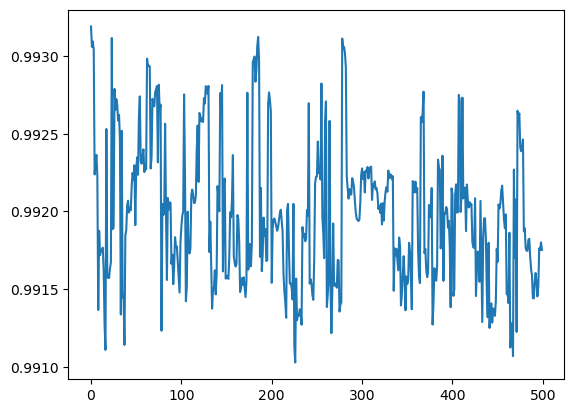

best_route: [2, 4, 3, 1, 5, 6, 7]
best distance: 160


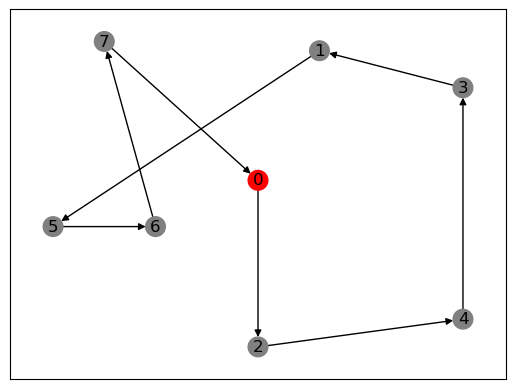

In [2]:
import numpy as np
import random,time
import matplotlib.pyplot as plt
from GetData import *

class GA():

    def __init__(self,disMatrix,MaxGens,pop_size,cross_rate,mutation_rate):
        "pop_size > 1 "
        self.disMatrix = disMatrix
        self.gene_size = len(disMatrix)  # 基因长度,路径长度，0为Depot
        self.pop_size = pop_size     #种群大小，每一代解的数量
        self.MaxGens = MaxGens       #最大迭代次数
        self.cross_rate = cross_rate   #交叉概率
        self.mutation_rate = mutation_rate  #变异概率

    def get_init_solution(self):
        init_routes = np.array([])
        route = np.arange(1,self.gene_size)   # 生成初始解
        for i in range(self.pop_size):
            np.random.shuffle(route)  
            init_routes = np.append(init_routes,route)
        return init_routes.reshape(self.pop_size,self.gene_size-1).astype(int)

    def get_route_distance(self,route):
        routes = list(route)  
        routes = [0] + routes +[0]
        total_distance = 0
        for i,n in enumerate(routes):
            if i != 0 :
                total_distance = total_distance + self.disMatrix[last_pos][n] 
            last_pos = n
        return total_distance

    def get_fitness(self,pop_routes):
        fitness = []
        for route in pop_routes:
            fitness.append(self.get_route_distance(route))
        fitness = 1 - fitness/np.sum(fitness) # 归一化后取反
        return np.array(fitness)

    def select(self,pop_routes):
        fitness = self.get_fitness(pop_routes)
        #轮盘赌的形式进行选择，适应度高的被选中的概率就大
        selected_label = np.random.choice(range(self.pop_size), size=self.pop_size, replace=True, p=fitness/np.sum(fitness))
        return pop_routes[selected_label]

    def crossover(self,pop_routes):
        for i in range(self.pop_size):
            if np.random.rand() < self.cross_rate :    
                obj = pop_routes[np.random.randint(self.pop_size)] #随机选一个交叉对象，也可以选到自己,生成新的一代
                cross_point = np.random.randint(self.gene_size)    #在DNA片段中随机选一个交叉点
                new_one = np.hstack((pop_routes[i][0:cross_point],obj[cross_point::])) #从交叉点往后交换基因片段
                if len(set(new_one)) < self.gene_size-1 :   #交换片段后可能是无效解，即有重复元素,处理一下
                    new_one__ = []
                    for num in new_one:
                        if num not in new_one__:
                            new_one__.append(num)
                        else:
                            for j in range(1,self.gene_size):
                                if j not in new_one__:
                                    new_one__.append(j)
                    pop_routes[i] = new_one__
                    continue
                pop_routes[i] = new_one
        return pop_routes

    def mutate(self,pop_routes):
        for i in range(self.pop_size): 
            if np.random.rand() < self.mutation_rate :
                pos1 = np.random.randint(0,self.gene_size-1)  # 随机选取某一个基因位置发生变异
                pos2 = np.random.randint(0,self.gene_size-1)  
                pop_routes[i][pos1],pop_routes[i][pos2] = pop_routes[i][pos2],pop_routes[i][pos1] #交换位置，完成变异
        return pop_routes

    def ga_evolution(self):
        routes = self.get_init_solution()   #生成初始解
        result=[]  #记录迭代过程中的信息
        while(self.MaxGens):
            self.MaxGens -=1
            routes = self.select(routes)
            routes = self.crossover(routes)
            routes = self.mutate(routes)
            result.append(max(self.get_fitness(routes)))  #记录一下迭代过程中的信息
        plt.plot(range(len(result)),result)
        plt.show()
        idx = np.where(self.get_fitness(routes)==max(self.get_fitness(routes)))   #挑出适应度最大的，可能不止一个
        best_id = random.sample(list(idx[0]), 1)  #从中拿一个
        best_route = routes[best_id]
        return np.squeeze(best_route).tolist()

if __name__ == "__main__":
    data=GetData()
    solomon_data = data.read_solomon(path ='R101.txt',customerNum=7)  #定义多少个点
    dismatrix = data.get_euclidean_distance_matrix(solomon_data.locations) 

    ga = GA(disMatrix=dismatrix,MaxGens=500,pop_size=100,cross_rate=0.3,mutation_rate=0.1) 
    best_route = ga.ga_evolution()
    print('best_route:',best_route)
    print('best distance:',ga.get_route_distance(best_route))

    data.plot_route(solomon_data.locations,[0]+best_route+[0])
